### PACKAGES

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from Functions.Processing import (
    load_transect_from_hdf5,
    find_contour_coordinates,
    create_spline_function,
    plot_topobathymetry_and_contours,
    interpolate_and_organize_height
)

# COQUIMBO

### READ TRASECTS

In [5]:
# load transects
all_transects = load_transect_from_hdf5('../Data/Coquimbo/Transects_N134_LonLat.h5')

hmax_local_nc = xr.open_dataset('../Data/Coquimbo/Maps_TodoFlowDepth_mw_9.1Baquedano.nc')
lon = hmax_local_nc['lon'].values-360
lat = hmax_local_nc['lat'].values

## Load bathy
bathy_nc = xr.open_dataset('../Data/Coquimbo/BaquedanoBathy.nc')

## longitude and latitude
grid_lon = bathy_nc['grid_lon'].values - 360
grid_lat = bathy_nc['grid_lat'].values
## Bathy
bathy    = bathy_nc['BaquedanoBathy'].values * -1
## Mesh
mesh_lon, mesh_lat = np.meshgrid(grid_lon, grid_lat)

## shoreline coordinate
shoreline = find_contour_coordinates(grid_lon, grid_lat, bathy, level=0)
## Shoreline approximation by spline
spline_function_x, spline_function_y, smoothed_points = create_spline_function(shoreline, 'cubic', 100, reduction_factor=40, smooth_window=10)

### LOAD HMAX FOR SIMULATIONS

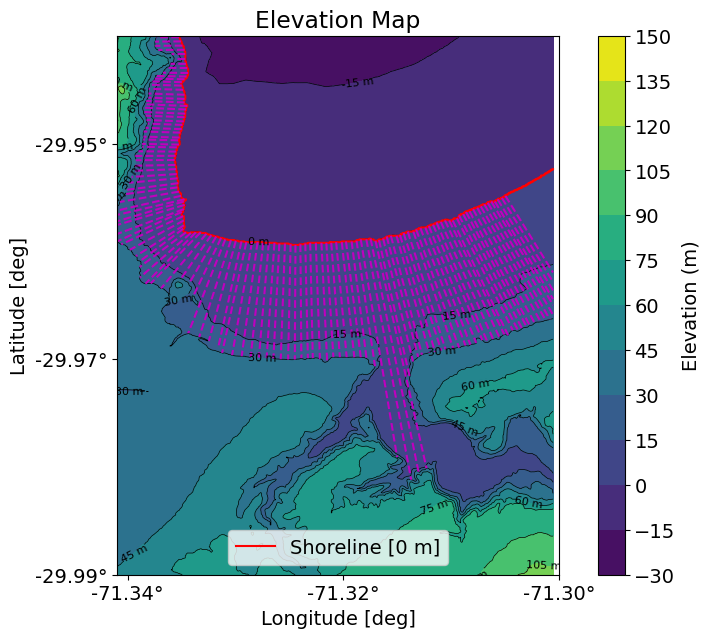

In [3]:
new_transects = {}

# Filtrar los transectos eliminando los primeros 13 y reasignando el key de manera consecutiva
for idx, (key, value) in enumerate(list(all_transects.items())[13:], start=1):  # Empezar desde el 14º transecto (índice 13)
    new_key = f'T{str(idx).zfill(3)}'  # Generar la clave 'T001', 'T002', etc.
    new_transects[new_key] = value  # Asignar el nuevo transecto con la clave renombrada

plt.rc('font', size=14)
# Plot topobathy and shoreline
fig, ax = plot_topobathymetry_and_contours(grid_lon, grid_lat, bathy, 
                                           elev_min   = -30, 
                                           elev_max   = 150, 
                                           elev_delta = 15, 
                                           z0_contour = shoreline,
                                           cmap       = 'viridis')
                                        
ax.set_aspect('equal')

for id in new_transects.keys():
    transecto_id = new_transects[id][['lon', 'lat', 'Elevation']]

    ax.plot(transecto_id['lon'], transecto_id['lat'], c='m', ls='--')

# Set axis labels
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')

# Configura los ticks de los ejes en grados con pasos de 0.02
ax.set_xticks(np.arange(-71.34, -71.3, 0.02))
ax.set_yticks(np.arange(-29.99, -29.94, 0.02))

# Muestra los ticks como grados en los ejes
ax.set_xticklabels([f'{x:.2f}°' for x in np.arange(-71.34, -71.3, 0.02)])
ax.set_yticklabels([f'{y:.2f}°' for y in np.arange(-29.99, -29.94, 0.02)])

ax.set_ylim(-29.99, -29.94)
ax.set_xlim(-71.341, -71.30)

#plt.savefig('Figures/Bathy_transects_coquimbo.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [6]:
# Interpolar y obtener el diccionario
interpolated_transects = interpolate_and_organize_height(new_transects, hmax_local_nc['FlowDepth'].values, lon, lat)

Interpolating simulations: 100%|██████████| 50/50 [00:01<00:00, 33.45it/s]


In [7]:
def fill_initial_nans(datadict, column):
    """
    Fills NaN values in the specified column from the beginning of the DataFrame until the first non-NaN value 
    with the first valid (non-NaN) value.

    Args:
    df (pd.DataFrame): The DataFrame where NaN values need to be filled.
    column (str): The column name where the NaN values will be filled.
    
    Returns:
    pd.DataFrame: The DataFrame with the NaN values filled in the specified column.
    """
    for key, df in datadict.items():
        # Find the first valid (non-NaN) value index
        first_valid_index = df[column].first_valid_index()

        if first_valid_index is not None:  # If there is a non-NaN value in the DataFrame
            # Get the first valid value
            first_valid_value = df[column].iloc[first_valid_index]
            
            # Fill NaN values from the start to the first non-NaN value using df.loc to avoid chained assignment
            df.loc[:first_valid_index, column] = first_valid_value
        
        datadict[key] = df
    return datadict

def calculate_polygon_and_area(first_points, last_points):
    """
    This function takes first_points and last_points arrays, creates a polygon by connecting
    the points, calculates the area, and stores both in a dictionary.

    Args:
    first_points (np.array): Array of first points (lon, lat) for each transect.
    last_points (np.array): Array of last points (lon, lat) for each transect.

    Returns:
    polygon (dict)
    area (dict)
    """
    # Combine the first and last points to create the polygon
    points = np.vstack([first_points, last_points[::-1]])
    # Create the polygon
    polygon = Polygon(points)

    # Create a GeoDataFrame from the polygon
    gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[polygon])
    # Convert to a metric projection, for example UTM zone 19S
    gdf_utm = gdf.to_crs(epsg=32719)
    # Calculate the area in square meters
    area_m2 = gdf_utm.area[0]

    return polygon, area_m2

In [29]:
interpolated_transectsV2 = fill_initial_nans(interpolated_transects, column='height')

In [8]:
# Bucle para escenarios
maxScen     = 50
scenList    = [f'S{str(ix).zfill(3)}' for ix in range(1, maxScen+1)]
polygonDict = dict()
areaDict    = dict()

for scen in tqdm(scenList):
    interpolated_transects2 = {key: value for key, value in interpolated_transectsV2.items() if key.startswith(scen)}

    plt.rc('font', size=14)
    fig, ax = plot_topobathymetry_and_contours(grid_lon, grid_lat, bathy, 
                                               elev_min   = -30, 
                                               elev_max   = 150, 
                                               elev_delta = 15, 
                                               z0_contour = None,
                                               cmap       = 'gray', alpha=0.5)

    ax.set_aspect('equal')
    first_points = []  # Almacenar los primeros puntos de cada transecto
    last_points = []   # Almacenar los últimos puntos de cada transecto

    for key, df in interpolated_transects2.items():
        keytransect = key.split('_')[-1]
        ax.plot(new_transects[keytransect]['lon'], new_transects[keytransect]['lat'], c='red', ls='--', lw=0.5, alpha=0.5)
        if not df['height'].isna().all():
            sns.scatterplot(x='lon', y='lat', hue='height', palette='viridis', data=df, legend=None, s=2)

        else:
            sns.scatterplot(x='lon', y='lat', data=df, legend=None, s=2)
        nan_sequence_start = df['height'].isna().rolling(100).sum().ge(100).idxmax()
        if nan_sequence_start < len(df):
            df.loc[nan_sequence_start:] = np.nan
        df=df.dropna(subset='height')
        
        try:
            # Obtener el primer punto de cada transecto
            first_points.append((df['lon'].values[0], df['lat'].values[0]))  # Primer punto (lon, lat)
            # Obtener el último punto de cada transecto
            last_points.append((df['lon'].values[-1], df['lat'].values[-1]))  # Último punto (lon, lat)
        except:
            pass

    # Convertir las listas a numpy arrays
    first_points = np.array(first_points)
    last_points = np.array(last_points)

    polygon, area_m2 = calculate_polygon_and_area(first_points, last_points)
    polygonDict[scen] = polygon
    areaDict[scen]    = area_m2

    norm = Normalize(vmin=0, vmax=10)
    sm = ScalarMappable(norm=norm, cmap='viridis')
    sm.set_array([])  # Only needed for ScalarMappable

    # Add the colorbar to the figure
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Height Error (%)')

    # Plotear el polígono en ax
    x, y = polygon.exterior.xy
    ax.add_patch(MplPolygon(np.c_[x, y], closed=True, edgecolor='cyan', fill=False, linewidth=2))
    ax.text(0.05, 0.95, f"Area: {area_m2/1e6:.2f} km²", transform=ax.transAxes, fontsize=12, verticalalignment='top', 
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))
    # Display the plot

    # Mostrar la figura final con el polígono
    plt.savefig(f'./Figures/Interpolated_height_coquimbo_{scen}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    #plt.show()

    # Limpiar la figura y cerrar para la siguiente iteración (si es necesario)
    plt.clf()  
    plt.close(fig)

  0%|          | 0/50 [00:00<?, ?it/s]


NameError: name 'interpolated_transectsV2' is not defined

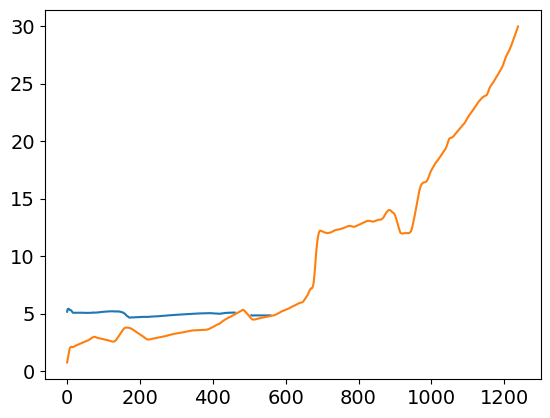

In [30]:
plt.figure()
tran_idx = 'T030'
scen_idx = 'S001'
plt.plot(interpolated_transectsV2[f'{scen_idx}_{tran_idx}']['elevation']+interpolated_transectsV2[f'{scen_idx}_{tran_idx}']['height'])
plt.plot(interpolated_transectsV2[f'{scen_idx}_{tran_idx}']['elevation'])


In [8]:
interpolated_transectsV2['S030_T010']

,lon,lat,x,y,elevation,height
0,-71.307976,-29.956087,-6857878.0,-3325125.75,0.084961,3.222132
1,-71.307968,-29.956095,-6857877.5,-3325126.50,0.121584,3.222132
2,-71.307968,-29.956104,-6857877.5,-3325127.50,0.156335,3.190625
3,-71.307961,-29.956112,-6857877.0,-3325128.50,0.189432,3.154440
4,-71.307961,-29.956120,-6857876.5,-3325129.25,0.221095,3.129449
...,...,...,...,...,...,...
1291,-71.302277,-29.966619,-6857330.0,-3326294.75,29.459700,NaN
1292,-71.302269,-29.966627,-6857329.5,-3326295.75,29.579056,NaN
1293,-71.302269,-29.966635,-6857329.0,-3326296.50,29.696407,NaN
1294,-71.302261,-29.966644,-6857328.5,-3326297.50,29.806723,NaN


In [9]:
def save_height_to_simulations(data, path):
    ''' 
    Saves a dictionary of dictionaries containing DataFrames to an HDF5 file.
    
    Parameters:
    data (dict): A dictionary where keys are scenarios, and values are dictionaries 
                 of transects. Each transect dictionary contains DataFrames.
    path (str): The file path where the HDF5 file will be saved.
    '''
    
    # Open an HDF5 file at the given path in write mode
    with pd.HDFStore(path, mode='w') as store:
        # Iterate over each scenario and its corresponding transects in the data dictionary
        for key, value in data.items():
                # Save the DataFrame to the HDF5 file with a key based on the scenario and transect
                store.put(key.strip('/'), value)
                
def summarize_initial_heights_by_S(data_dict):
    """
    This function calculates the min, max, mean, and std of the initial height (df['height'].iloc[0]) 
    for all transects 'T00X' within each 'S00X'.

    Parameters:
    data_dict (dict): Dictionary where the keys are 'S00X_T00X' and the values are DataFrames with a 'height' column.

    Returns:
    dict: A dictionary where each key is 'S00X' and the value is a list with [min, max, mean, std] 
          of the initial heights for all 'T00X' transects within that 'S00X'.
    """
    result_dict = {}

    # Iterate through the dictionary and collect initial heights for each 'S00X'
    for key, df in data_dict.items():
        s_key = key.split('_')[0]  # Extract the 'S00X' part of the key
        initial_height = df['height'].iloc[0]  # Get the first value of the 'height' column
        
        # If 'S00X' is not already in the result_dict, initialize an empty list
        if s_key not in result_dict:
            result_dict[s_key] = []

        # Append the initial height to the list for the corresponding 'S00X'
        result_dict[s_key].append(initial_height)

    # Now calculate min, max, mean, and std for each 'S00X'
    summary_dict = {}
    for s_key, heights in result_dict.items():
        # Convert the list of heights to a NumPy array for easier calculation
        heights_array = np.array(heights)
        summary_dict[s_key] = [np.nanmin(heights_array), np.nanmax(heights_array), np.nanmean(heights_array), np.nanstd(heights_array)]

    return summary_dict

In [10]:
def initial_heights_by_scenario(data_dict):
    """
    This function calculates the min, max, mean, and std of the initial height (df['height'].iloc[0]) 
    for all transects 'T00X' within each 'S00X'.

    Parameters:
    data_dict (dict): Dictionary where the keys are 'S00X_T00X' and the values are DataFrames with a 'height' column.

    Returns:
    dict: A dictionary where each key is 'S00X' and the value is a list with [min, max, mean, std] 
          of the initial heights for all 'T00X' transects within that 'S00X'.
    """
    result_dict = {}

    # Iterate through the dictionary and collect initial heights for each 'S00X'
    for key, df in data_dict.items():
        s_key = key.split('_')[0]  # Extract the 'S00X' part of the key
        initial_height = df['height'].iloc[0]  # Get the first value of the 'height' column
        
        # If 'S00X' is not already in the result_dict, initialize an empty list
        if s_key not in result_dict:
            result_dict[s_key] = []

        # Append the initial height to the list for the corresponding 'S00X'
        result_dict[s_key].append(initial_height)

    # Now calculate min, max, mean, and std for each 'S00X'
    summary_dict = {}
    for s_key, heights in result_dict.items():
        # Convert the list of heights to a NumPy array for easier calculation
        heights_array = np.array(heights)
        summary_dict[s_key] = [np.nanmin(heights_array), np.nanmax(heights_array), np.nanmean(heights_array), np.nanstd(heights_array)]

    return summary_dict


In [11]:
initialH = initial_heights_by_scenario(interpolated_transects)

In [12]:
initialH['S001']

[np.float32(2.3510742),
 np.float32(6.575413),
 np.float32(5.1451144),
 np.float32(0.98049116)]

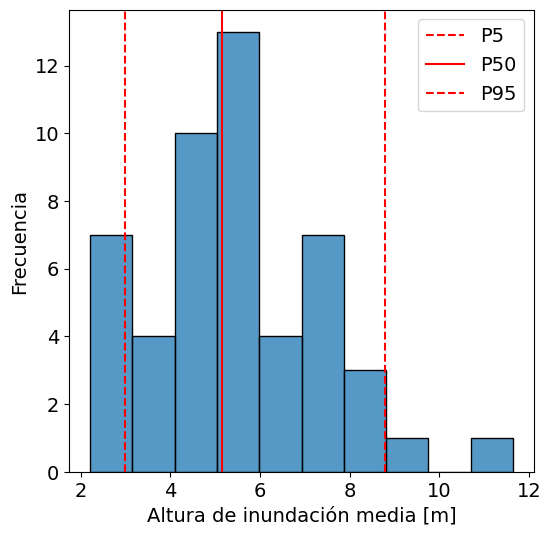

In [20]:
means = [stats[2] for s_key, stats in initialH.items() if s_key.startswith('S')]

# Calculate percentiles
p5 = np.percentile(means, 5)
p50 = np.percentile(means, 50)  # This is also the median
p95 = np.percentile(means, 95)

# Create the plot using seaborn
plt.figure(figsize=(6, 6))
sns.histplot(means, bins=10, kde=False, edgecolor='black')

# Mark percentiles with vertical lines
plt.axvline(p5, color='red', linestyle='dashed', linewidth=1.5, label='P5')
plt.axvline(p50, color='red', linestyle='-', linewidth=1.5, label='P50')
plt.axvline(p95, color='red', linestyle='dashed', linewidth=1.5, label='P95')

# Add labels and title
plt.xlabel('Altura de inundación media [m]')
plt.ylabel('Frecuencia')
#plt.title('Histogram of Mean Heights for S001 to S050 with Percentiles')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [27]:
save_height_to_simulations(interpolated_transectsV2, '../Data/Coquimbo/Height_for_simulation.h5')

# VIÑA DEL MAR

### READ TRASECTS

In [7]:
# load transects
all_transects = load_transect_from_hdf5('../Data/Vina/Transects_N106_LonLat.h5')

hmax_maps = np.load('../Data/Vina/hmax_map_vina.npz')
lon_min, lon_max = hmax_maps['extent'][:2]
lat_min, lat_max = hmax_maps['extent'][-2:]
simulations, n_lat, n_lon = hmax_maps['hmax_map'].shape
lon = np.linspace(lon_min, lon_max, n_lon)
lat = np.linspace(lat_max, lat_min, n_lat)

## Load bathy
## Get spatial data from asc file
grid_lon, grid_lat, bathy = load_asc_file('../Data/Vina/Mapa_Vina.asc')
grid_lon = grid_lon[0,:] ## To obtain only the vector of longitudes
grid_lat = grid_lat[:,0] ## To obtain only the vector of latitudes

## shoreline coordinate
shoreline = find_contour_coordinates(grid_lon, grid_lat, bathy, level=0)

## Mesh
mesh_lon, mesh_lat = np.meshgrid(grid_lon, grid_lat)

## Shoreline approximation by spline
spline_function_x, spline_function_y, smoothed_points = create_spline_function(shoreline, 'cubic', 50, reduction_factor=40, smooth_window=20)

### LOAD HMAX FOR SIMULATIONS

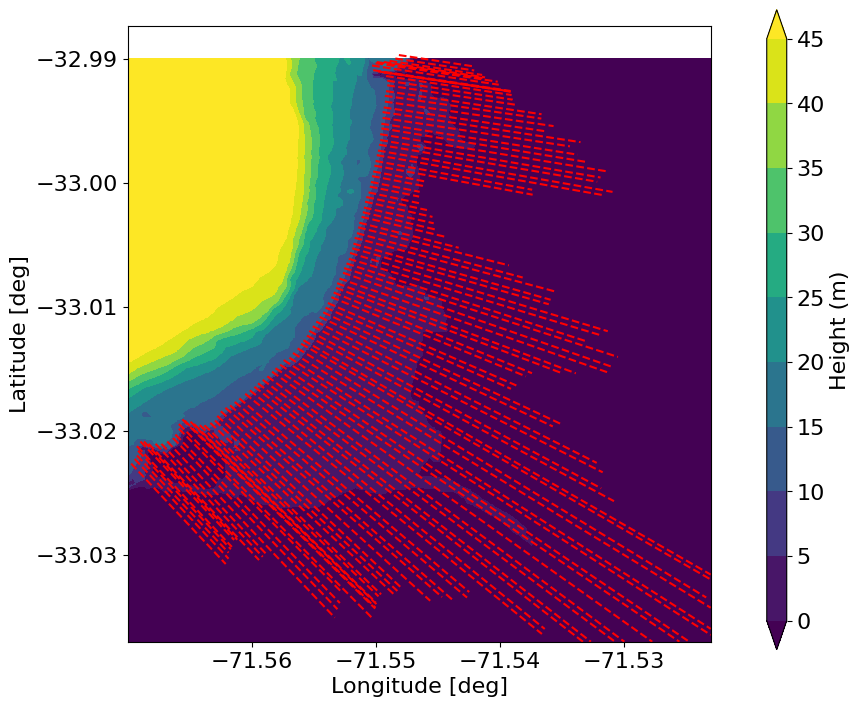

In [8]:
# Assuming you have the data `grid_lon`, `grid_lat`, and `bathy` extracted
hmax_local = hmax_maps['hmax_map'][49,:,:]

# Plot parameters
hmin, hmax = 0, 50
height_interval = 5

# Create figure and axis
plt.rcParams.update({'font.size':16})
fig, ax = plt.subplots(figsize=(10, 8))

# Create filled contour plot for height
cf_height = ax.contourf(lon, lat, hmax_local, 
                         levels=np.arange(hmin, hmax, height_interval), 
                         cmap='viridis', extend='both', alpha=1)

for id in all_transects.keys():
    transecto_id = all_transects[id][['lon', 'lat', 'Elevation']]

    ax.plot(transecto_id['lon'], transecto_id['lat'], c='red', ls='--')

# Set axis labels
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
#ax.set_aspect('equal')  # Ensure 1:1 aspect ratio

# Create an additional axis for the colorbars
cbar_ax_height = fig.add_axes([0.86, 0.1, 0.02, 0.8])
cbar_height = fig.colorbar(cf_height, cax=cbar_ax_height)
cbar_height.set_label('Height (m)')
ax.set_aspect('equal', adjustable='box')
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
#plt.subplots_adjust(right=0.9)  # Adjust the space to fit the colorbars

plt.show()

In [9]:
new_transects = {}

for key, value in all_transects.items():
    new_key = key.split('/')[-1]
    new_transects[new_key] = value

In [10]:
# Interpolar y obtener el diccionario
random_indices = np.random.choice(1800, 100, replace=False)
hmax_maps2 = hmax_maps['hmax_map'][random_indices, :, :]
interpolated_transects = interpolate_and_organize_height(new_transects, hmax_maps2, lon, lat)

Interpolating simulations: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


In [11]:
interpolated_transects.keys()

dict_keys(['S001_T001', 'S001_T002', 'S001_T003', 'S001_T004', 'S001_T005', 'S001_T006', 'S001_T007', 'S001_T008', 'S001_T009', 'S001_T010', 'S001_T011', 'S001_T012', 'S001_T013', 'S001_T014', 'S001_T015', 'S001_T016', 'S001_T017', 'S001_T018', 'S001_T019', 'S001_T020', 'S001_T021', 'S001_T022', 'S001_T023', 'S001_T024', 'S001_T025', 'S001_T026', 'S001_T027', 'S001_T028', 'S001_T029', 'S001_T030', 'S001_T031', 'S001_T032', 'S001_T033', 'S001_T034', 'S001_T035', 'S001_T036', 'S001_T037', 'S001_T038', 'S001_T039', 'S001_T040', 'S001_T041', 'S001_T042', 'S001_T043', 'S001_T044', 'S001_T045', 'S001_T046', 'S001_T047', 'S001_T048', 'S001_T049', 'S001_T050', 'S001_T051', 'S001_T052', 'S001_T053', 'S001_T054', 'S001_T055', 'S001_T056', 'S001_T057', 'S001_T058', 'S001_T059', 'S001_T060', 'S001_T061', 'S001_T062', 'S001_T063', 'S001_T064', 'S001_T065', 'S001_T066', 'S001_T067', 'S001_T068', 'S001_T069', 'S001_T070', 'S001_T071', 'S001_T072', 'S001_T073', 'S001_T074', 'S001_T075', 'S001_T076', '

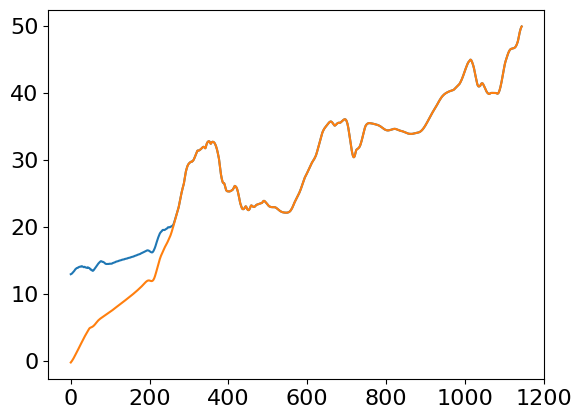

In [12]:
plt.figure()
tran_idx = 'T001'
scen_idx = 'S001'
plt.plot(interpolated_transects[f'{scen_idx}_{tran_idx}']['elevation']+interpolated_transects[f'{scen_idx}_{tran_idx}']['height'])
plt.plot(interpolated_transects[f'{scen_idx}_{tran_idx}']['elevation'])
#plt.xlim(0,500)

In [13]:
def filter_dataframes_by_height(data_dict):
    '''
    Filters a dictionary of DataFrames, keeping only those DataFrames where all non-NaN values
    in the 'height' column are less than the specified threshold.

    Parameters:
    data_dict (dict): Dictionary of DataFrames to filter.
    threshold (float): The maximum value for the 'height' column to keep a DataFrame.

    Returns:
    dict: A filtered dictionary of DataFrames.
    list: A list of keys that did not meet the criteria and were removed.
    '''
    filtered_dict = {}
    removed_keys = []

    for key, df in data_dict.items():
        try:
            # Filter DataFrame to keep only rows where 'height' < threshold (and 'height' is not NaN)
            df['height']   = df['height'].replace(0, np.nan)
            last_pto_flood = (df['elevation'] + df['height']).dropna()
            max_elev       = df['elevation'].dropna().max()
            if max_elev > last_pto_flood.iloc[-1]:
                filtered_dict[key] = df
            else:
                removed_keys.append(key)
        except:
            removed_keys.append(key)
        
    return filtered_dict, removed_keys

# Ejemplo de uso con tu diccionario de dataframes
filtered_dict, removed_keys = filter_dataframes_by_height(interpolated_transects)

# Imprimir las claves que no cumplen con el criterio
print("DataFrames removed (keys):", removed_keys)
print("Total df removed:", len(removed_keys))

DataFrames removed (keys): ['S001_T106', 'S002_T106', 'S003_T106', 'S004_T106', 'S005_T106', 'S006_T106', 'S007_T096', 'S007_T097', 'S007_T106', 'S008_T106', 'S009_T106', 'S010_T106', 'S011_T106', 'S012_T106', 'S013_T106', 'S014_T096', 'S014_T097', 'S014_T106', 'S015_T106', 'S016_T106', 'S017_T106', 'S018_T106', 'S019_T106', 'S020_T106', 'S021_T106', 'S022_T106', 'S023_T106', 'S024_T106', 'S025_T106', 'S026_T106', 'S027_T106', 'S028_T106', 'S029_T106', 'S030_T106', 'S031_T106', 'S032_T106', 'S033_T106', 'S034_T076', 'S034_T077', 'S034_T106', 'S035_T106', 'S036_T106', 'S037_T106', 'S038_T106', 'S039_T106', 'S040_T106', 'S041_T106', 'S042_T106', 'S043_T096', 'S043_T106', 'S044_T106', 'S045_T106', 'S046_T106', 'S047_T106', 'S048_T106', 'S049_T106', 'S050_T106', 'S051_T106', 'S052_T106', 'S053_T106', 'S054_T106', 'S055_T106', 'S056_T106', 'S057_T106', 'S058_T106', 'S059_T106', 'S060_T106', 'S061_T106', 'S062_T096', 'S062_T097', 'S062_T106', 'S063_T106', 'S064_T106', 'S065_T106', 'S066_T106

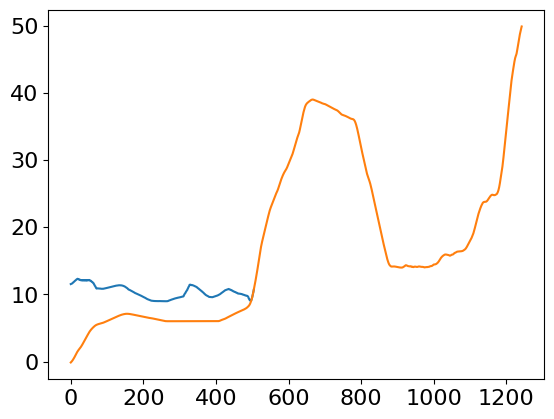

In [14]:
plt.figure()
tran_idx = 'T090'
scen_idx = 'S008'
plt.plot(interpolated_transects[f'{scen_idx}_{tran_idx}']['elevation']+interpolated_transects[f'{scen_idx}_{tran_idx}']['height'])
plt.plot(interpolated_transects[f'{scen_idx}_{tran_idx}']['elevation'])
#plt.xlim(0,500)


In [15]:
filtered_dict.keys()

dict_keys(['S001_T001', 'S001_T002', 'S001_T003', 'S001_T004', 'S001_T005', 'S001_T006', 'S001_T007', 'S001_T008', 'S001_T009', 'S001_T010', 'S001_T011', 'S001_T012', 'S001_T013', 'S001_T014', 'S001_T015', 'S001_T016', 'S001_T017', 'S001_T018', 'S001_T019', 'S001_T020', 'S001_T021', 'S001_T022', 'S001_T023', 'S001_T024', 'S001_T025', 'S001_T026', 'S001_T027', 'S001_T028', 'S001_T029', 'S001_T030', 'S001_T031', 'S001_T032', 'S001_T033', 'S001_T034', 'S001_T035', 'S001_T036', 'S001_T037', 'S001_T038', 'S001_T039', 'S001_T040', 'S001_T041', 'S001_T042', 'S001_T043', 'S001_T044', 'S001_T045', 'S001_T046', 'S001_T047', 'S001_T048', 'S001_T049', 'S001_T050', 'S001_T051', 'S001_T052', 'S001_T053', 'S001_T054', 'S001_T055', 'S001_T056', 'S001_T057', 'S001_T058', 'S001_T059', 'S001_T060', 'S001_T061', 'S001_T062', 'S001_T063', 'S001_T064', 'S001_T065', 'S001_T066', 'S001_T067', 'S001_T068', 'S001_T069', 'S001_T070', 'S001_T071', 'S001_T072', 'S001_T073', 'S001_T074', 'S001_T075', 'S001_T076', '

In [17]:
def save_height_to_simulations(data, path):
    ''' 
    Saves a dictionary of dictionaries containing DataFrames to an HDF5 file.
    
    Parameters:
    data (dict): A dictionary where keys are scenarios, and values are dictionaries 
                 of transects. Each transect dictionary contains DataFrames.
    path (str): The file path where the HDF5 file will be saved.
    '''
    
    # Open an HDF5 file at the given path in write mode
    with pd.HDFStore(path, mode='w') as store:
        # Iterate over each scenario and its corresponding transects in the data dictionary
        for key, value in data.items():
                # Save the DataFrame to the HDF5 file with a key based on the scenario and transect
                store.put(key.strip('/'), value)

In [18]:
save_height_to_simulations(filtered_dict, '../Data/Vina/Height_for_simulation.h5')

# VALPARAISO

### READ TRASECTS

In [8]:
# load transects
all_transects = load_transects_from_netcdf('./Processed/Valparaiso_transects_N113_LonLat.nc')

hmax_maps = np.load('./Data/hmax_map_valpo.npz')
lon_min, lon_max = hmax_maps['extent'][:2]
lat_min, lat_max = hmax_maps['extent'][-2:]
simulations, n_lat, n_lon = hmax_maps['hmax_map'].shape
lon = np.linspace(lon_min, lon_max, n_lon)
lat = np.linspace(lat_max, lat_min, n_lat)

## Load bathy
## Get spatial data from asc file
grid_lon, grid_lat, bathy = load_asc_file('./Data/Mapa_Valparaiso.asc')
grid_lon = grid_lon[0,:] ## To obtain only the vector of longitudes
grid_lat = grid_lat[:,0] ## To obtain only the vector of latitudes

## shoreline coordinate
shoreline = find_contour_coordinates(grid_lon, grid_lat, bathy, level=0)

## Mesh
mesh_lon, mesh_lat = np.meshgrid(grid_lon, grid_lat)

## Shoreline approximation by spline
spline_function_x, spline_function_y, smoothed_points = create_spline_function(shoreline, 'cubic', 50, reduction_factor=40, smooth_window=20)

### LOAD HMAX FOR SIMULATIONS

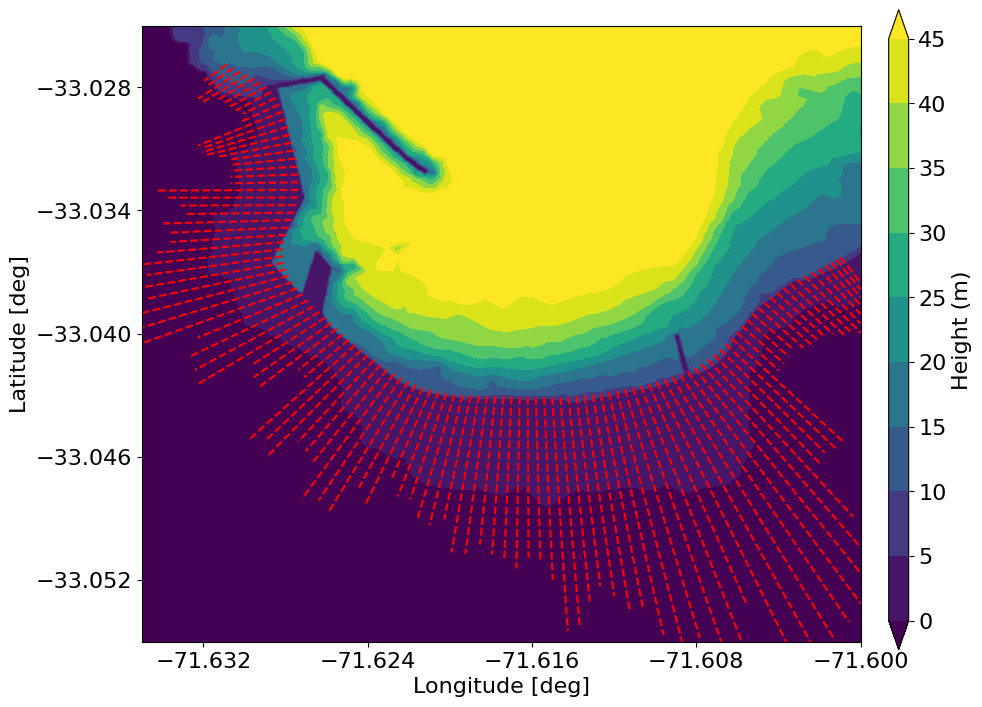

In [9]:
# Assuming you have the data `grid_lon`, `grid_lat`, and `bathy` extracted
hmax_local = hmax_maps['hmax_map'][49,:,:]

# Plot parameters
hmin, hmax = 0, 50
height_interval = 5

# Create figure and axis
plt.rcParams.update({'font.size':16})
fig, ax = plt.subplots(figsize=(10, 8))
# Plot parameters
hmin, hmax = 0, 50
height_interval = 5
# Create filled contour plot for height
hmax_local_nc['FlowDepth'].values
cf_height = ax.contourf(lon, lat, hmax_local, 
                         levels=np.arange(hmin, hmax, height_interval), 
                         cmap='viridis', extend='both', alpha=1)

for id in all_transects.keys():
    transecto_id = all_transects[id][['lon', 'lat', 'Elevation']]

    ax.plot(transecto_id['lon'], transecto_id['lat'], c='red', ls='--')

# Set axis labels
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
#ax.set_aspect('equal')  # Ensure 1:1 aspect ratio

# Create an additional axis for the colorbars
cbar_ax_height = fig.add_axes([0.9, 0.1, 0.02, 0.8])
cbar_height = fig.colorbar(cf_height, cax=cbar_ax_height)
cbar_height.set_label('Height (m)')
ax.set_aspect('equal', adjustable='box')
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
#plt.subplots_adjust(right=0.9)  # Adjust the space to fit the colorbars

plt.show()

In [10]:
# Interpolar y obtener el diccionario
random_indices = np.random.choice(1800, 100, replace=False)
hmax_maps2 = hmax_maps['hmax_map'][random_indices, :, :]
interpolated_transects = interpolate_and_organize_height(all_transects, hmax_maps2, lon, lat)

Interpolating simulations: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


In [11]:
save_height_to_simulations(interpolated_transects, './Processed/Valparaiso_height_for_simulation.h5')

# CARTAGENA

### READ TRASECTS

In [61]:
# load transects
all_transects = load_transect_from_hdf5('../Data/Cartagena/Transects_N183_LonLat.h5')

hmax_maps = np.load('../Data/Cartagena/hmax_map_cartagena.npz')
lon_min, lon_max = hmax_maps['extent'][:2]
lat_min, lat_max = hmax_maps['extent'][-2:]
simulations, n_lat, n_lon = hmax_maps['hmax_map'].shape
lon = np.linspace(lon_min, lon_max, n_lon)
lat = np.linspace(lat_max, lat_min, n_lat)

## Load bathy
## Get spatial data from asc file
grid_lon, grid_lat, bathy = load_asc_file('../Data/Cartagena/Mapa_Cartagena.asc')
grid_lon = grid_lon[0,:] ## To obtain only the vector of longitudes
grid_lat = grid_lat[:,0] ## To obtain only the vector of latitudes

## shoreline coordinate
shoreline = find_contour_coordinates(grid_lon, grid_lat, bathy, level=0)

## Mesh
mesh_lon, mesh_lat = np.meshgrid(grid_lon, grid_lat)

## Shoreline approximation by spline
spline_function_x, spline_function_y, smoothed_points = create_spline_function(shoreline, 'cubic', 50, reduction_factor=40, smooth_window=20)

### LOAD HMAX FOR SIMULATIONS

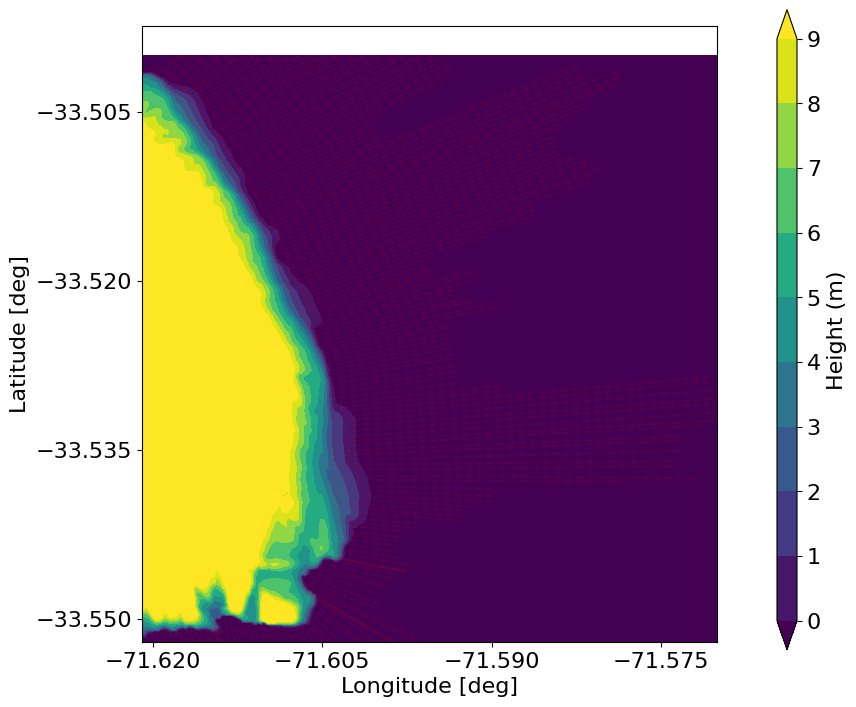

In [62]:
# Assuming you have the data `grid_lon`, `grid_lat`, and `bathy` extracted
hmax_local = hmax_maps['hmax_map'][1,:,:]

# Plot parameters
hmin, hmax = 0, 10
height_interval = 1

# Create figure and axis
plt.rcParams.update({'font.size':16})
fig, ax = plt.subplots(figsize=(10, 8))

# Create filled contour plot for height
cf_height = ax.contourf(lon, lat, hmax_local, 
                         levels=np.arange(hmin, hmax, height_interval), 
                         cmap='viridis', extend='both', alpha=1)

for id in all_transects.keys():
    transecto_id = all_transects[id][['lon', 'lat', 'Elevation']]

    ax.plot(transecto_id['lon'], transecto_id['lat'], c='red', ls='--', alpha=0.1)

# Set axis labels
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
#ax.set_aspect('equal')  # Ensure 1:1 aspect ratio

# Create an additional axis for the colorbars
cbar_ax_height = fig.add_axes([0.86, 0.1, 0.02, 0.8])
cbar_height = fig.colorbar(cf_height, cax=cbar_ax_height)
cbar_height.set_label('Height (m)')
ax.set_aspect('equal', adjustable='box')
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
#plt.subplots_adjust(right=0.9)  # Adjust the space to fit the colorbars

plt.show()

In [63]:
new_transects = {}

for key, value in all_transects.items():
    new_key = key.split('/')[-1]
    new_transects[new_key] = value

In [64]:
# Interpolar y obtener el diccionario
random_indices = np.random.choice(1800, 100, replace=False)
hmax_maps2 = hmax_maps['hmax_map'][random_indices, :, :]
interpolated_transects = interpolate_and_organize_height(new_transects, hmax_maps2, lon, lat)

Interpolating simulations: 100%|██████████| 100/100 [00:04<00:00, 20.31it/s]


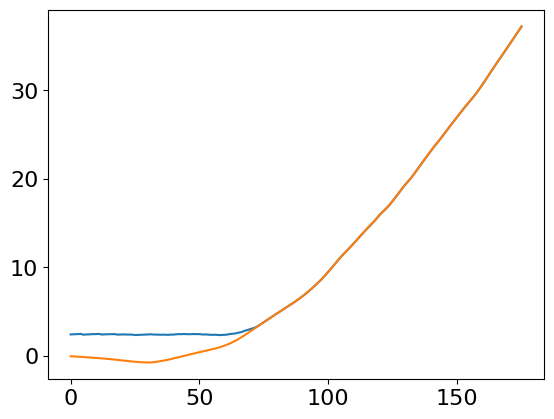

In [65]:
plt.figure()
tran_idx = 'T016'
scen_idx = 'S001'
plt.plot(interpolated_transects[f'{scen_idx}_{tran_idx}']['elevation']+interpolated_transects[f'{scen_idx}_{tran_idx}']['height'])
plt.plot(interpolated_transects[f'{scen_idx}_{tran_idx}']['elevation'])
#plt.xlim(0,25)

In [72]:
def filter_dataframes_by_height(data_dict):
    '''
    Filters a dictionary of DataFrames, keeping only those DataFrames where all non-NaN values
    in the 'height' column are less than the specified threshold.

    Parameters:
    data_dict (dict): Dictionary of DataFrames to filter.
    threshold (float): The maximum value for the 'height' column to keep a DataFrame.

    Returns:
    dict: A filtered dictionary of DataFrames.
    list: A list of keys that did not meet the criteria and were removed.
    '''
    filtered_dict = {}
    removed_keys = []

    for key, df in data_dict.items():
        try:
            # Filter DataFrame to keep only rows where 'height' < threshold (and 'height' is not NaN)
            df                  = df[df['elevation']>=0] 
            df.loc[:, 'height'] = df['height'].replace(0, np.nan).copy()
            last_pto_flood      = (df['elevation'] + df['height']).dropna()
            max_elev            = df['elevation'].dropna().max()
            
            if max_elev > last_pto_flood.iloc[-1]:
                df.reset_index(drop=True, inplace=True)
                filtered_dict[key] = df
            else:
                removed_keys.append(key)
        except:
            removed_keys.append(key)
        
    return filtered_dict, removed_keys

# Ejemplo de uso con tu diccionario de dataframes
filtered_dict, removed_keys = filter_dataframes_by_height(interpolated_transects)

# Imprimir las claves que no cumplen con el criterio
print("DataFrames removed (keys):", removed_keys)
print("Total df removed:", len(removed_keys))

DataFrames removed (keys): []
Total df removed: 0


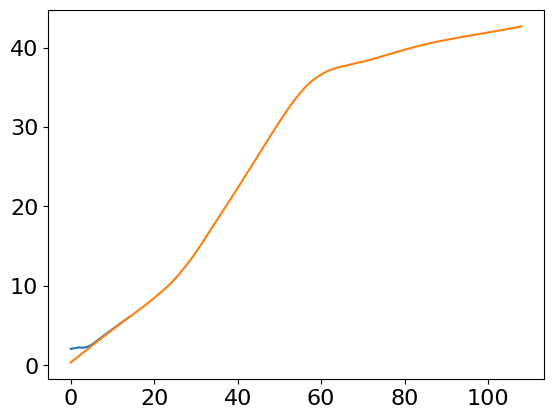

In [74]:
plt.figure()
tran_idx = 'T003'
scen_idx = 'S001'
plt.plot(filtered_dict[f'{scen_idx}_{tran_idx}']['elevation']+filtered_dict[f'{scen_idx}_{tran_idx}']['height'])
plt.plot(filtered_dict[f'{scen_idx}_{tran_idx}']['elevation'])
#plt.xlim(0,500)


In [75]:
def save_height_to_simulations(data, path):
    ''' 
    Saves a dictionary of dictionaries containing DataFrames to an HDF5 file.
    
    Parameters:
    data (dict): A dictionary where keys are scenarios, and values are dictionaries 
                 of transects. Each transect dictionary contains DataFrames.
    path (str): The file path where the HDF5 file will be saved.
    '''
    
    # Open an HDF5 file at the given path in write mode
    with pd.HDFStore(path, mode='w') as store:
        # Iterate over each scenario and its corresponding transects in the data dictionary
        for key, value in data.items():
                # Save the DataFrame to the HDF5 file with a key based on the scenario and transect
                store.put(key.strip('/'), value)

In [76]:
save_height_to_simulations(filtered_dict, '../Data/Cartagena/Height_for_simulation.h5')

/Users/fjsaez/.pyenv/versions/Froude/lib/python3.11/site-packages/tables/group.py:484: PerformanceWarning: group ``/`` is exceeding the recommended maximum number of children (16384); be ready to see PyTables asking for *lots* of memory and possibly slow I/O.
  warnings.warn("""\


(0.0, 20.0)

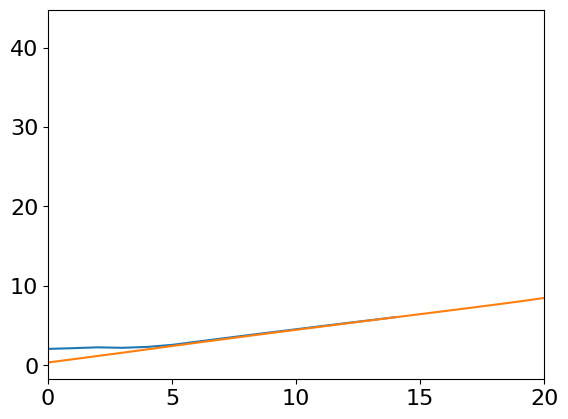

In [78]:
plt.figure()
tran_idx = 'T003'
scen_idx = 'S001'
plt.plot(filtered_dict[f'{scen_idx}_{tran_idx}']['elevation']+filtered_dict[f'{scen_idx}_{tran_idx}']['height'])
plt.plot(filtered_dict[f'{scen_idx}_{tran_idx}']['elevation'])
plt.xlim(0,20)